In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import coint
import warnings
warnings.filterwarnings('ignore')

## Generating a digital marketing dataset with realistic ad metrics

The data simulates daily advertising performance metrics of Facebook Ads and Google Adwords campaigns over a fixed time period.

    Ensuring clicks ≤ views, conversions ≤ clicks
    Click-Through-Rate (CTR) = clicks / views
    Conversion rate = conversions / clicks
    Cost Per Click (CPC) = ad cost / clicks
    Introducing controlled differences for A/B testing (e.g. Adwords has higher CTR, Facebook cheaper CPC)

In [2]:
np.random.seed(42)

# Number of days
dates = pd.date_range(start="2024-01-01", periods=365)

# Campaign names
fb_campaigns = ["FB_A", "FB_B"]
adw_campaigns = ["ADW_A", "ADW_B"]

data = []

for date in dates:
    fb_views = np.random.randint(8000, 15000)
    fb_ctr = np.random.uniform(0.012, 0.025)   # Facebook CTR
    fb_clicks = int(fb_views * fb_ctr)
    fb_conv_rate = np.random.uniform(0.08, 0.15)
    fb_conversions = int(fb_clicks * fb_conv_rate)
    fb_cost = fb_clicks * np.random.uniform(0.3, 0.6)

    adw_views = np.random.randint(6000, 12000)
    adw_ctr = np.random.uniform(0.02, 0.04)     # Adwords higher CTR
    adw_clicks = int(adw_views * adw_ctr)
    adw_conv_rate = np.random.uniform(0.12, 0.2)
    adw_conversions = int(adw_clicks * adw_conv_rate)
    adw_cost = adw_clicks * np.random.uniform(0.6, 1.2)

    data.append([
        date,
        np.random.choice(fb_campaigns),
        fb_views, fb_clicks, fb_conversions, fb_cost,
        fb_clicks / fb_views,
        fb_conversions / fb_clicks if fb_clicks > 0 else 0,
        fb_cost / fb_clicks if fb_clicks > 0 else 0,

        np.random.choice(adw_campaigns),
        adw_views, adw_clicks, adw_conversions, adw_cost,
        adw_clicks / adw_views,
        adw_conversions / adw_clicks if adw_clicks > 0 else 0,
        adw_cost / adw_clicks if adw_clicks > 0 else 0
    ])

columns = [
    "date",
    "facebook_campaign",
    "facebook_views",
    "facebook_clicks",
    "facebook_conversions",
    "facebook_ad_cost",
    "facebook_ctr",
    "facebook_conversion_rate",
    "facebook_cpc",

    "adwords_campaign",
    "adwords_views",
    "adwords_clicks",
    "adwords_conversions",
    "adwords_ad_cost",
    "adwords_ctr",
    "adwords_conversion_rate",
    "adwords_cpc"
]

df = pd.DataFrame(data, columns=columns)

df.head()


,date,facebook_campaign,facebook_views,facebook_clicks,facebook_conversions,facebook_ad_cost,facebook_ctr,facebook_conversion_rate,facebook_cpc,adwords_campaign,adwords_views,adwords_clicks,adwords_conversions,adwords_ad_cost,adwords_ctr,adwords_conversion_rate,adwords_cpc
0,2024-01-01,FB_B,8860,127,17,60.839991,0.014334,0.133858,0.479055,ADW_B,6466,142,22,113.631974,0.021961,0.154930,0.800225
1,2024-01-02,FB_B,8130,99,14,54.423546,0.012177,0.141414,0.549733,ADW_A,8433,199,26,155.726524,0.023598,0.130653,0.782545
2,2024-01-03,FB_A,12843,157,18,65.933452,0.012225,0.114650,0.419958,ADW_B,8047,207,30,180.843892,0.025724,0.144928,0.873642
3,2024-01-04,FB_B,12658,214,31,94.166178,0.016906,0.144860,0.440029,ADW_A,9556,307,41,196.182503,0.032126,0.133550,0.639031
4,2024-01-05,FB_B,10363,200,21,60.957975,0.019299,0.105000,0.304790,ADW_A,7363,182,31,175.811635,0.024718,0.170330,0.965998


## Exploratory Analysis

In [3]:
df.shape

(365, 17)

In [4]:
df.dtypes

date                        datetime64[ns]
facebook_campaign                   object
facebook_views                       int64
facebook_clicks                      int64
facebook_conversions                 int64
facebook_ad_cost                   float64
facebook_ctr                       float64
facebook_conversion_rate           float64
facebook_cpc                       float64
adwords_campaign                    object
adwords_views                        int64
adwords_clicks                       int64
adwords_conversions                  int64
adwords_ad_cost                    float64
adwords_ctr                        float64
adwords_conversion_rate            float64
adwords_cpc                        float64
dtype: object

In [5]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,365,2024-07-01 00:00:00.000000256,2024-01-01 00:00:00,2024-04-01 00:00:00,2024-07-01 00:00:00,2024-09-30 00:00:00,2024-12-30 00:00:00,NaN
facebook_views,365.0,11568.635616,8002.0,9855.0,11525.0,13279.0,14991.0,1990.09178
facebook_clicks,365.0,212.709589,99.0,166.0,207.0,254.0,359.0,58.684602
facebook_conversions,365.0,24.20274,9.0,18.0,23.0,29.0,51.0,8.304804
facebook_ad_cost,365.0,95.670932,33.966878,72.752739,91.522444,114.568294,204.245124,31.701759
facebook_ctr,365.0,0.01836,0.011947,0.014921,0.018253,0.021851,0.024913,0.003833
facebook_conversion_rate,365.0,0.11357,0.074324,0.096552,0.114094,0.132231,0.149837,0.02049
facebook_cpc,365.0,0.450819,0.300133,0.38834,0.448064,0.526276,0.598749,0.083591
adwords_views,365.0,8962.876712,6009.0,7538.0,8901.0,10413.0,11999.0,1714.180182
adwords_clicks,365.0,265.706849,126.0,216.0,256.0,313.0,469.0,70.915009


## Campaign Performance Comparison

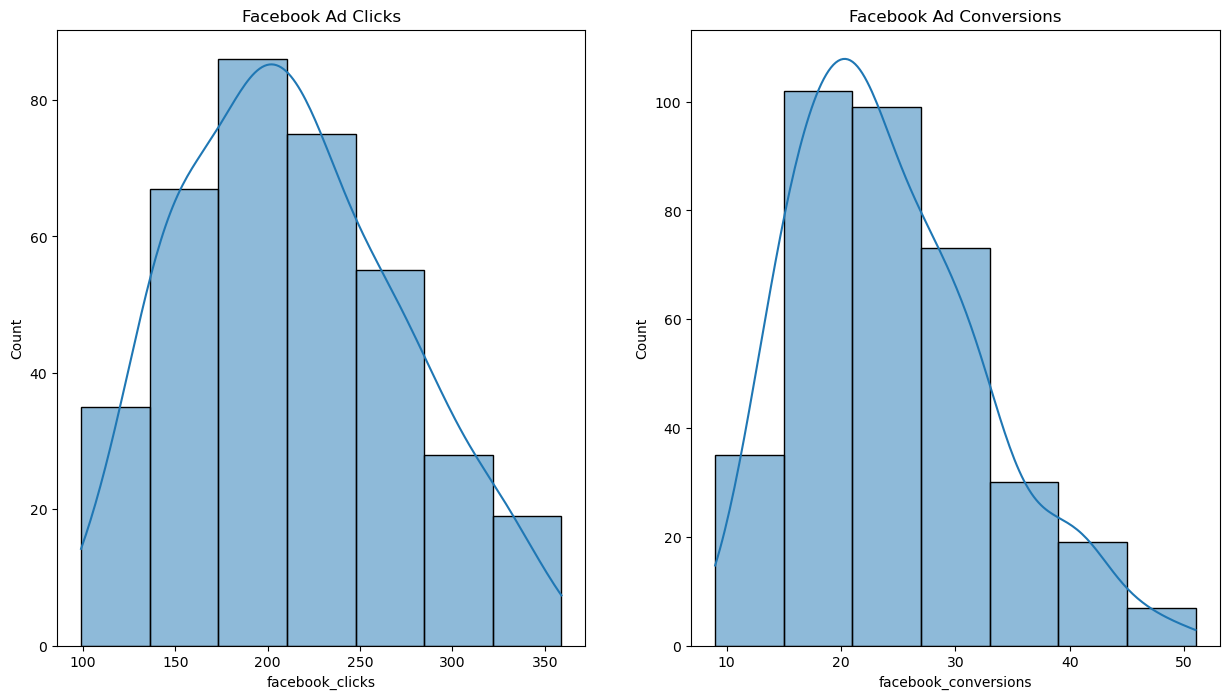

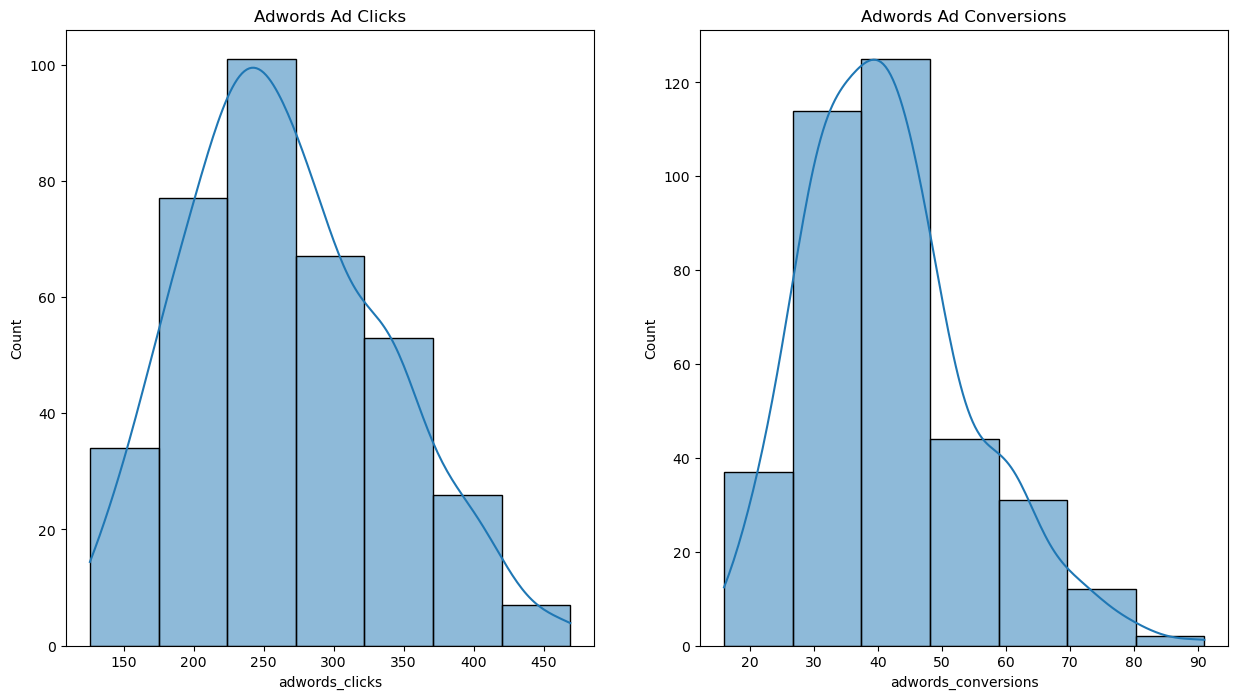

In [6]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
plt.title('Facebook Ad Clicks')
sns.histplot(df['facebook_clicks'], bins = 7, edgecolor = 'k', kde = True)

plt.subplot(1,2,2)
plt.title('Facebook Ad Conversions')
sns.histplot(df['facebook_conversions'], bins = 7, edgecolor = 'k', kde = True)
plt.show()

plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
plt.title('Adwords Ad Clicks')
sns.histplot(df['adwords_clicks'], bins = 7, edgecolor = 'k', kde = True)

plt.subplot(1,2,2)
plt.title('Adwords Ad Conversions')
sns.histplot(df['adwords_conversions'], bins = 7, edgecolor = 'k', kde = True)
plt.show()

Symmetrical shape suggests the number of clicks and conversions is relatively evenly distributed ie no outliers

## Comparing conversion distribution by platform

In [7]:
def create_conversion_category(conversion_col):
    category = []
    for conversion in df[conversion_col]:
        if conversion < 10:
            category.append('Less than 10')
        elif conversion < 21:
            category.append('10 - 20')
        elif conversion < 31:
            category.append('21 - 30')
        elif conversion < 41:
            category.append('31 - 40')
        elif conversion < 51:
            category.append('41 - 50')
        else:
            category.append('More than 50')
    return category

df['facebook_conversion_category'] = create_conversion_category('facebook_conversions')
df['adwords_conversion_category'] = create_conversion_category('adwords_conversions')

In [8]:
facebook = pd.DataFrame(df['facebook_conversion_category'].value_counts()).reset_index().rename(columns = {'facebook_conversion_category': 'category'})
facebook

,category,count
0,21 - 30,150
1,10 - 20,135
2,31 - 40,58
3,41 - 50,19
4,Less than 10,2
5,More than 50,1


In [9]:
adwords = pd.DataFrame(df['adwords_conversion_category'].value_counts()).reset_index().rename(columns = {'adwords_conversion_category': 'category'})
adwords

,category,count
0,31 - 40,119
1,41 - 50,103
2,More than 50,74
3,21 - 30,59
4,10 - 20,10


In [10]:
category_df = pd.merge(facebook, adwords, on = 'category', how = 'outer').fillna(0)
category_df

,category,count_x,count_y
0,10 - 20,135,10.0
1,21 - 30,150,59.0
2,31 - 40,58,119.0
3,41 - 50,19,103.0
4,Less than 10,2,0.0
5,More than 50,1,74.0


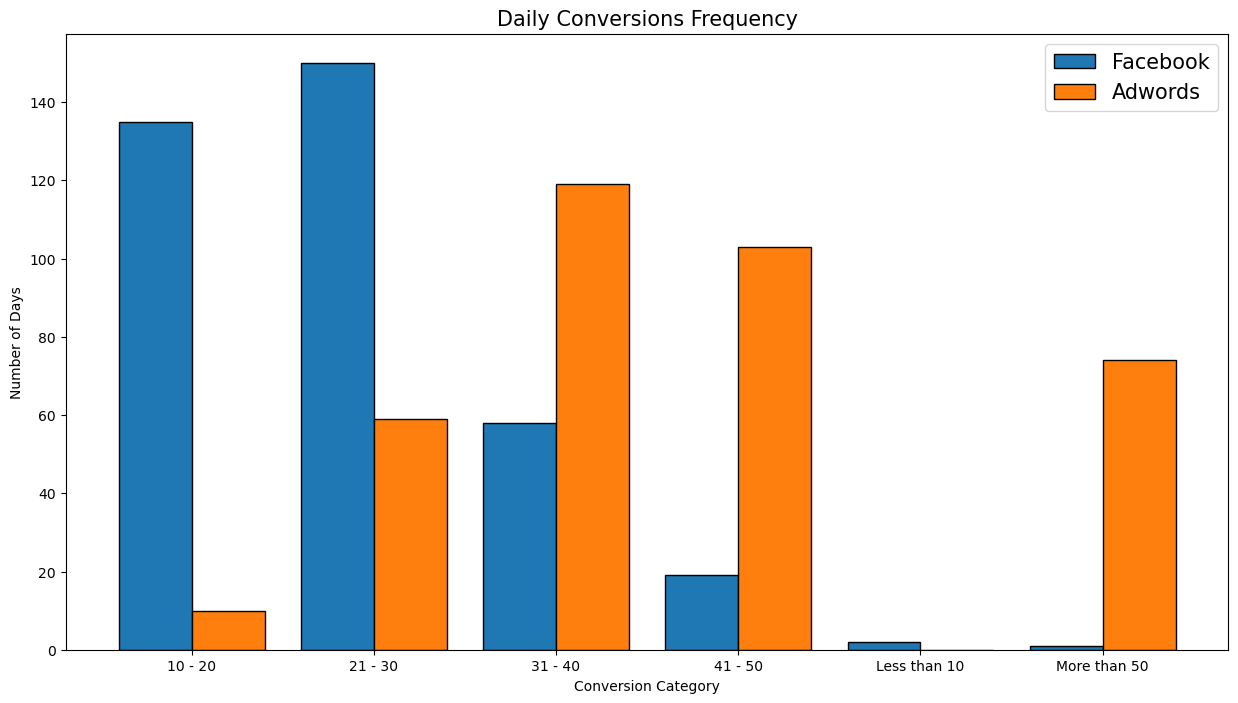

In [11]:
X_axis = np.arange(len(category_df))

plt.figure(figsize = (15, 8))
plt.bar(X_axis - 0.2, category_df['count_x'], 0.4, label = 'Facebook', linewidth = 1, edgecolor = 'k')
plt.bar(X_axis + 0.2, category_df['count_y'], 0.4, label = 'Adwords', linewidth = 1, edgecolor = 'k')

plt.xticks(X_axis, category_df['category'])
plt.xlabel("Conversion Category")
plt.ylabel("Number of Days")
plt.title("Daily Conversions Frequency", fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

Facebook conversions are concentrated in the lower–mid ranges: most days fall between 10–30 conversions, with very few high-conversion days.

AdWords outperforms at higher conversion levels: the majority of days are 31+ conversions, including many 41–50 and 50+ days.

    AdWords delivers higher and more consistent conversion volume than Facebook, while Facebook performs better for moderate, steady conversions.


### Correlation btwn ad clicks and sales on both platforms

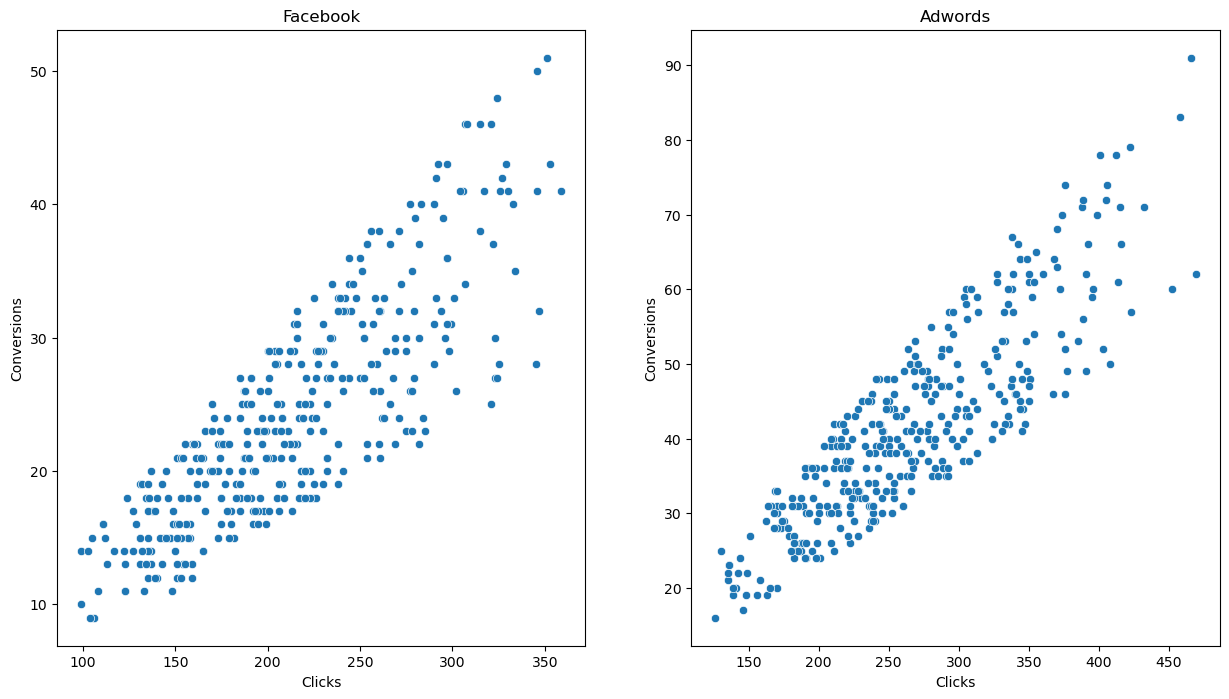

In [12]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('Facebook')
sns.scatterplot(x = df['facebook_clicks'], y = df['facebook_conversions'])
plt.xlabel('Clicks')
plt.ylabel('Conversions')

plt.subplot(1,2,2)
plt.title('Adwords')
sns.scatterplot(x = df['adwords_clicks'], y = df['adwords_conversions'])
plt.xlabel('Clicks')
plt.ylabel('Conversions')

plt.show()

In [13]:
facebook_corr = df[['facebook_conversions', 'facebook_clicks']].corr()
facebook_corr

,facebook_conversions,facebook_clicks
facebook_conversions,1.000000,0.833574
facebook_clicks,0.833574,1.000000


In [14]:
adwords_corr = df[['adwords_conversions', 'adwords_clicks']].corr()
adwords_corr

,adwords_conversions,adwords_clicks
adwords_conversions,1.000000,0.862051
adwords_clicks,0.862051,1.000000


Both platforms show a strong positive relationship between clicks and conversions, meaning more clicks generally lead to more conversions.

    AdWords has a slightly stronger correlation (0.862) than Facebook (0.834), AdWords conversions are more directly driven by click volume.

## Hypothesis Testing

### Welch’s t-test to compare mean daily conversions between Facebook Ads and Google AdWords.

Hypothesis: Advertising on facebook will result in a greater number of conversions compared to AdWords.

    Null Hypothesis: No difference in number of conversions between facebook and AdWords or greater number from facebook.
    Alternative Hypothesis: Number of conversions from AdWords is greater than number of conversions from facebook.

The results indicate a statistically significant difference in conversion performance between the two platforms (α = 0.05).

In [18]:
print('facebook Mean Conversion:', round(df['facebook_conversions'].mean(), 2))
print('AdWords Mean Conversion:', round(df['adwords_conversions'].mean(), 2))

facebook Mean Conversion: 24.2
AdWords Mean Conversion: 41.58


In [16]:
from scipy.stats import ttest_ind

t_stats, p_value = ttest_ind(a = df['facebook_conversions'], b = df['adwords_conversions'], equal_var = False)
print('\nT Statistics', t_stats, '\np-value', p_value)

if p_value < 0.05:
    print("\n p-value is less than significance value, Reject the Null Hypothesis")
else:
    print("\n p-value is greater than significance value, Accept the Null Hypothesis")


T Statistics -21.638348470657792 
p-value 8.045287234758926e-78

 p-value is less than significance value, Reject the Null Hypothesis


At the 5% significance level, we reject the null hypothesis and conclude that Google AdWords generates significantly higher average conversions than Facebook Ads.

## Regression Analysis

fitting a simple linear regression predicting AdWords conversions from clicks and evaluating how well clicks explain conversions using R² and mean squared error.

In [17]:
X = df[['adwords_clicks']]
y = df[['adwords_conversions']]

reg_model = LinearRegression()
reg_model.fit(X, y)
prediction = reg_model.predict(X)

r2 = r2_score(y, prediction) * 100
mse = mean_squared_error(y, prediction)
print('Accuracy (R2 Score):', round(r2, 2), '%')
print('Mean Squared Error:', round(mse, 2))

Accuracy (R2 Score): 74.31 %
Mean Squared Error: 42.64


About 74% of the variation in AdWords conversions can be explained by clicks, indicating a strong positive relationship, while the average prediction error (MSE ≈ 42.64) shows some day-to-day variability remains unexplained.

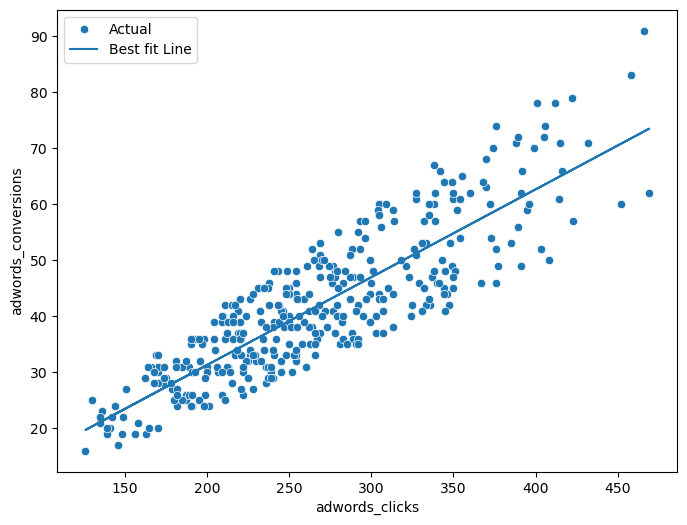

In [19]:
plt.figure(figsize=(8,6))
sns.scatterplot(x = df['adwords_clicks'], y =  df['adwords_conversions'], label = 'Actual')
plt.plot(df['adwords_clicks'], prediction, label = 'Best fit Line')
plt.legend()
plt.show()

In [20]:
print(f'{50} Clicks: {round(reg_model.predict([[50]])[0][0], 2)} Expected Conversions')
print(f'{100} Clicks: {round(reg_model.predict([[100]])[0][0], 2)} Expected Conversions')

50 Clicks: 7.75 Expected Conversions
100 Clicks: 15.59 Expected Conversions


## Analyzing AdWords Campaign Metrics over Time

In [21]:
adword_df = df[['date', 'adwords_views', 'adwords_clicks', 'adwords_conversions', 'adwords_ad_cost',
                'adwords_ctr', 'adwords_conversion_rate', 'adwords_cpc']]

In [23]:
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.weekday

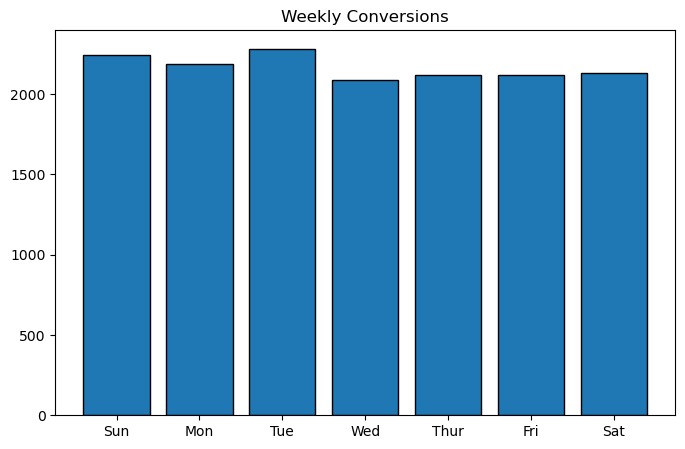

In [24]:
plt.figure(figsize=(8,5))
plt.title('Weekly Conversions')
weekly_conversions = df.groupby('week')[['adwords_conversions']].sum()
weeks = ['Sun','Mon','Tue','Wed','Thur','Fri','Sat']
plt.bar(weeks, weekly_conversions['adwords_conversions'], edgecolor = 'k')
plt.show()

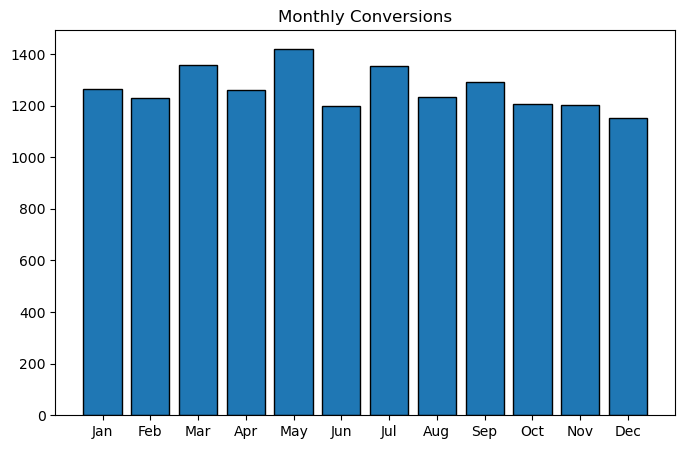

In [25]:
plt.figure(figsize=(8,5))
plt.title('Monthly Conversions')
monthly_conversions = df.groupby('month')[['adwords_conversions']].sum()
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.bar(months, monthly_conversions['adwords_conversions'], edgecolor = 'k')
plt.show()

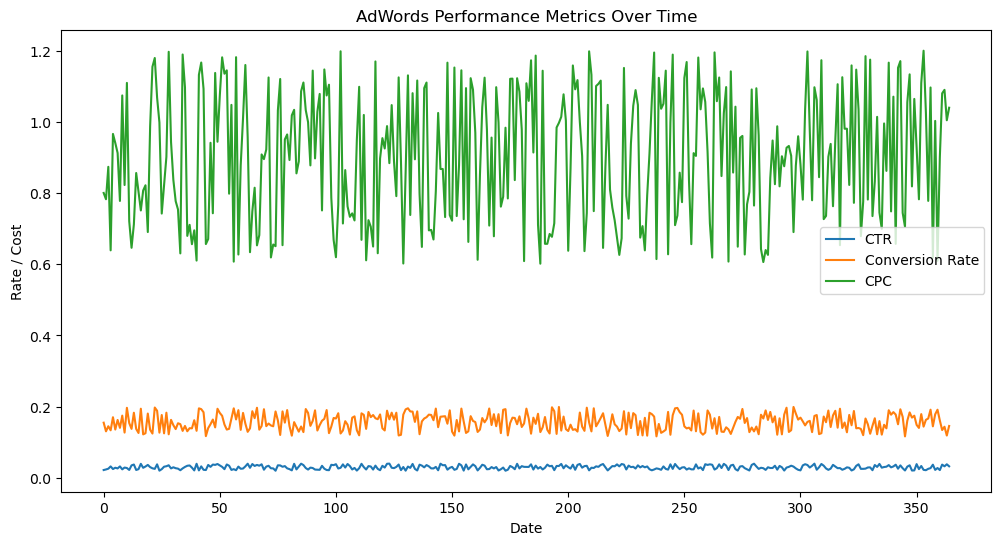

In [22]:
plt.figure(figsize=(12,6))
plt.plot(adword_df.index, adword_df['adwords_ctr'], label='CTR')
plt.plot(adword_df.index, adword_df['adwords_conversion_rate'], label='Conversion Rate')
plt.plot(adword_df.index, adword_df['adwords_cpc'], label='CPC')
plt.title('AdWords Performance Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Rate / Cost')
plt.legend()
plt.show()

### Cointegration test to check if AdWords ad cost and conversions have a long-term equilibrium relationship (move together over time).

In [66]:
score, p_value, _ = coint(df['adwords_ad_cost'], df['adwords_conversions'])
print('Test Score:', score)
print('P-value:', p_value)

if p_value < 0.05:
    print("\n p-value is less than significance value, Reject the Null Hypothesis")
else:
    print("\n p-value is greater than significance value, Accept the Null Hypothesis")

Test Score: -7.28384674226322
P-value: 1.783054144825452e-09

 p-value is less than significance value, Reject the Null Hypothesis


AdWords ad cost and conversions are statistically cointegrated, meaning they exhibit a stable long-term relationship over time.

In practical terms, changes in ad spend are consistently associated with changes in conversions.